# Spatial Interpolation of Measured Soil Loss Rates

This Jupyter Notebook demonstrates how to spatially interpolate soil loss rates measured at discrete locations across a catchment.  The soil loss rates are derived from field measurements, such as those obtained using fallout radionuclide techniques. The resulting interpolated map of soil loss will be a valuable tool for assessing soil erosion risk and evaluating the performance of soil erosion models.  This process allows us to create a continuous representation of soil loss across the entire catchment, even in areas where direct measurements are not available.

<left><img src="images/soil_sampling.png" width="300px">

## **Steps**

### 0. Import the necessary libraries
We begin by importing the Python libraries required for data manipulation, geospatial operations, visualization, and interpolation.

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For handling tabular data (e.g., soil loss estimates)
import rasterio  # For reading and writing raster (geospatial) data
import matplotlib.pyplot as plt  # For plotting and visualizations
from ipywidgets import interactive  # For creating interactive widgets
from scipy import interpolate  # For spatial interpolation methods
from tools.file_IO import open_raster, save_as_raster

### 1. Load the DEM Raster  
A Digital Elevation Model (DEM) is essential for understanding the topography of the catchment.  It provides the elevation data needed for context in our soil loss interpolation. When you load a raster file (like a DEM) using Rasterio in Python, you get both the raw elevation data *and* important metadata.

a. **DEM (Digital Elevation Model)**

This is the core data – a 2D array (or sometimes a multi-dimensional array for multi-band rasters) of elevation values. Each cell in the array corresponds to a location on the ground, and the value in that cell represents the elevation at that point.   

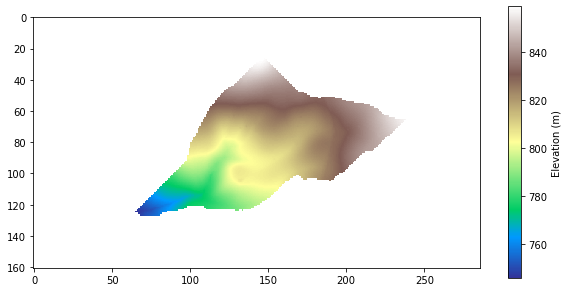

In [2]:
# Open the Digital Elevation Model (DEM) raster file
raster = rasterio.open('inputs/catchment_dem.tif')

# Read the first band of the DEM (assuming it's a single-band raster)
dem = raster.read(1)  # Extracts a 2D array representing elevation values

# Get the number of rows and columns in the DEM
n_rows, n_cols = dem.shape

# Plot DEM
plt.figure(figsize=(10, 5))
plt.imshow(dem, cmap='terrain', origin='upper') # 'terrain' colormap is suitable for visualizing elevation.
plt.colorbar(label='Elevation (m)')

b. **Metadata**

Metadata is descriptive information *about* your DEM.  It's crucial for correctly interpreting and using the data. Key metadata components include:
- **Data Type**: The type of data used to store elevation values (e.g., integers, floating-point numbers). This affects precision and storage size.
- **NoData Values**: Values used to represent areas where elevation data is missing or invalid.   
- **Height and Width**: The dimensions of the DEM grid (Nnumber of rows and columns).
- **Coordinate Reference System (CRS)**: Tells you how the DEM is georeferenced (e.g., latitude/longitude, UTM). This is crucial for knowing where your data is located on Earth.

In [3]:
# Print metadata to understand raster properties
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 286,
 'height': 161,
 'count': 1,
 'crs': CRS.from_epsg(25830),
 'transform': Affine(5.0, 0.0, 409412.5,
        0.0, -5.0, 4132972.5)}

- **Transform**

The transform (often called an affine transform) is a mathematical function that links the pixel coordinates in your DEM array to real-world coordinates in your chosen Spatial Reference System.
It essentially tells you how to go from a pixel in your array to a specific location on the ground (and vice versa).
The transform is usually represented as a 3x3 matrix, but Rasterio provides tools to work with it more easily.

In [4]:
# Print the affine transformation (links pixel coordinates to real-world coordinates)
raster.transform

Affine(5.0, 0.0, 409412.5,
       0.0, -5.0, 4132972.5)

**Why are Metadata and Transform Important?** Without metadata and the transform, your DEM is just a grid of numbers. You wouldn't know where those numbers correspond to on the Earth's surface.

### 2. Load soil loss estimates data
We load the soil loss data from an Excel file. This data should contain the location (coordinates) and the corresponding soil loss rate for each measurement point.

In [5]:
# Load soil loss dataset from an Excel file
soil_loss_df = pd.read_excel('inputs/SL_Pu_Montefrio.xlsx', index_col = 'ID')
soil_loss_df.head() # Display the first few rows

,X,Y,SL_Pu
ID,,,
M1-1,410179.490,4132795.830,-7.052360
M1-2,410101.480,4132795.520,10.955225
M1-3,409982.560,4132693.420,32.581203
M1-4,410119.803,4132703.995,-17.549303
M1-5,410150.174,4132699.801,-24.809081


### 3. Convert UTM coordinates to gridcell indices (row number, column number)
Convert soil loss sample locations from UTM coordinates to raster grid indices.

In [6]:
row_ids, col_ids = [], [] # Initialize the lists to store row and column indices
n_points = soil_loss_df.shape[0]  # Number of soil loss points

# Convert each coordinate to a corresponding row and column in the DEM grid
for i in range(n_points):
    col = (soil_loss_df['X'].iloc[i] - raster.transform[2]) / raster.transform[0]
    row = (soil_loss_df['Y'].iloc[i] - raster.transform[5]) / raster.transform[4]
    row_ids.append(int(np.round(row))) 
    col_ids.append(int(np.round(col)))

### 4. Plot the DEM and Sample Points
   - The DEM is displayed using a terrain colormap (`cmap='terrain'`).
   - The extracted elevation points are overlaid on the DEM using `plt.scatter()`, with colors representing their elevation values.
   - A color bar, legend, and title are added for clarity.

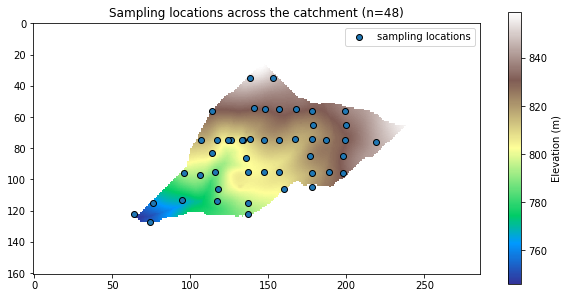

In [7]:
# Plot DEM with sampling points
plt.figure(figsize=(10, 5))
plt.imshow(dem, cmap='terrain', origin='upper')
plt.colorbar(label='Elevation (m)')
plt.scatter(col_ids, row_ids, edgecolor='k', cmap='coolwarm', label='sampling locations')
plt.title(f'Sampling locations across the catchment (n={n_points})')
plt.legend()

### 5. Interpolate soil loss estimates
Now we perform the spatial interpolation.  We use `scipy.interpolate.griddata` to interpolate the soil loss values from the scattered points to a regular grid covering the entire DEM.  Several interpolation methods are available (nearest neighbor, linear, cubic).

We also use `ipywidgets` to add interactivity: a dropdown menu allows the user to select different interpolation methods and see the resulting changes in the interpolated soil loss map.

In [14]:
def interactive_spatial_interpolation(inter_method):
    
    # Perform interpolation with the selected method
    grid_x, grid_y = np.meshgrid(np.arange(0, n_rows), np.arange(0, n_cols), indexing='ij')
    SL_inter = interpolate.griddata(np.column_stack([row_ids, col_ids]), soil_loss_df['SL_Pu'], (grid_x, grid_y), 
                                    method=inter_method)
    SL_inter[np.isnan(dem)] = np.nan
    
    # Plot interpolated soil loss map
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(SL_inter)  # Display the interpolated map
    plt.colorbar(label='soil loss (tn/ha/year)') # Add a color bar indicating soil loss rates
    plt.scatter(col_ids, row_ids, edgecolor='k') # Overlay the sampling pointds
    plt.title(f'Interpolated soil loss map (method = {inter_method})')  # Add a title
    plt.show()  # Display the plot 
    
    return SL_inter, inter_method

# Create an interactive widget for method selection
outputs = interactive(interactive_spatial_interpolation, inter_method = ['nearest', 'linear', 'cubic'])
outputs

interactive(children=(Dropdown(description='inter_method', options=('nearest', 'linear', 'cubic'), value='near…

In [15]:
# Get the output (interpolated map and interpolation method) from the interactive widget
SL_inter, inter_method = outputs.result

Now that we have the results from the interactive selection, we can save the raster

### 7. Save the interpolated map as a raster file

Finally, we save the interpolated soil loss map as a GeoTIFF raster file. This allows you to use the map in other GIS software or analyses.  It's crucial to preserve the geospatial information (the transform) so the map is correctly georeferenced.

In [17]:
# Define the output file path
output_file = f'soil_loss_interpolated_map({inter_method}).tif'

save_as_raster('outputs/',output_file, SL_inter, raster.meta)

print(f"Interpolated soil loss map saved to: {output_file}")

Interpolated soil loss map saved to: soil_loss_interpolated_map(linear).tif
